## Spherical triangulation of data points

As we are working with data at high latitudes where a cylindrical, flat-Earth approximation is a poor choice, we use the `stripy` spherical triangulation package to build an interpolating triangulation. 



In [2]:
import os.path as path
import stripy as stripy
import numpy as np

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt

In [5]:
datafile = "Data/Moho-Alaska/picks_1999-Apr2018_clean.txt"
moho_data_raw = np.genfromtxt(datafile, delimiter=" ", 
                           comments=None, 
                           skip_header=1, 
                           missing_values=0.0, 
                           filling_values=0.0, 
                           invalid_raise=False, 
                           dtype=[('lon',float), ('lat',float), ('moh',float), ('cnt', float), ('stn', object)])

moho_data1 = moho_data_raw[::-1] ## as we can easily remove old entries this way

In [7]:
## Uniqueness problem:

## 1. Some locations may be repeated after re-processing.
## 2. Some stations may be re-occupied with new names

### 1. - for repeated stations, take the last entry in the array as, in this 
###      case it corresponds to more recent (more events) information

vals, index, inverse, counts = np.unique(moho_data1['stn'], return_counts=True, return_index=True, return_inverse=True)
moho_data2 = moho_data1[index]

print("Unique stations: {}".format(index.shape[0]))

print(moho_data1['stn'][np.where(counts>1)])

# Now check for repeated lon/lat pairs (this would be rare if we pre-processed as above)

lonlat2 = moho_data2[['lon','lat']]

vals, index, inverse, counts = np.unique(lonlat2, return_counts=True, return_index=True, return_inverse=True)
moho_data3 = moho_data2[index]

## Data reduction - average values in points with more than one station

print("Unique locations: {}".format(index.shape[0]))

for i in index:
    locs = np.where(inverse == i)[0]
    if locs.shape[0] > 1:
        print("Location {} has multiple stations {}".format(moho_data2[["lon","lat"]][i], moho_data2['stn'][locs]))
        moho_data3['moh'][i] = moho_data2['moh'][locs].mean()

## To avoid confusion later ... 

moho_data = moho_data3


Unique stations: 378
['TA-C18K-' 'TA-B22K-' 'TA-A22K-' 'TA-A21K-' 'CN-YUK6-' 'YV-NANC-'
 'YV-LSKI-' 'YV-INDI-' 'YV-HOPJ-' 'YV-AVAL-' 'YV-ALPI-' 'YO-TIDE-'
 'YE-PIC4-' 'YE-PIC2-' 'XR-SAG-01' 'XR-RBY-01' 'XR-NOM-01' 'XR-LVG-01'
 'XR-LMW-01' 'XL-BBB-' 'XF-TRIP-' 'XF-STEW-' 'XF-LUPN-' 'XF-KAVU-'
 'XF-DOST-' 'XE-SLT-01' 'XE-HURN-01' 'XE-GNR-01' 'XE-BYR-01' 'US-EGAK-00'
 'TA-P29M-' 'TA-P19K-' 'TA-N25K-' 'TA-K20K-' 'TA-J29M-' 'TA-J25K-'
 'TA-J20K-' 'TA-H21K-' 'TA-G22K-' 'TA-F22K-' 'TA-E25K-' 'TA-E24K-'
 'TA-E23K-' 'TA-C27K-' 'CN-YUK8-' 'CN-YUK7-' 'CN-YUK3-']
Unique locations: 377
Location (-153.131805, 61.882301) has multiple stations ['YE-PIC1-01' 'YE-PIC2-']


In [4]:
## Write this data to a numpy file for processing later

np.savez("AlaskaMoho.npz", alaska_moho=moho_data)

In [5]:
# Naive meshing of the regional data

datagrid = stripy.sTriangulation(np.radians(moho_data['lon']), np.radians(moho_data['lat']), permute=True)
print("Points in triangulation: {}".format(datagrid.npoints))

Points in triangulation: 377


In [6]:
## Use gmt colour palette

import pycpt

cptdict = pycpt.load.find_cpt_files("cpt")

msmcmap = pycpt.load.gmtColormap("cpt/moho_20-40km.cpt")

### Plot triangulation / data 

Plot the data and the triangulation.

In [7]:
global_extent     = [-180.0, 180.0, -90.0, 90.0]


fig = plt.figure(figsize=(20, 10), facecolor="none")
ax1  = plt.subplot(121, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))

ax1.set_extent([-175,-130,50,72])

grat = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m",
                                           name="graticules_5")

ocean = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m", 
                                            name="ocean")

land = cartopy.feature.NaturalEarthFeature(category="physical", scale="50m", 
                                            name="land")



ax1.coastlines(resolution="50m",color="#000000", linewidth=0.5, zorder=2)
ax1.add_feature(ocean, alpha=0.5, zorder=0, facecolor="#BBBBCC")
ax1.add_feature(land, alpha=1.0,  zorder=1, facecolor="#EEEEEE")

ax1.add_feature(grat, linewidth=0.5, 
                      linestyle="--",
                      edgecolor="#000000", 
                      facecolor="None", zorder=3)


ax1.coastlines(resolution="50m",color="#000000", linewidth=0.5, zorder=3)

lons0 = np.degrees(datagrid.lons)
lats0 = np.degrees(datagrid.lats)
moho  = moho_data['moh']

## Triangulation


for tri in datagrid.simplices: 
    ax1.plot( [lons0[tri[0]], lons0[tri[1]], lons0[tri[2]], lons0[tri[0]]],
             [lats0[tri[0]], lats0[tri[1]], lats0[tri[2]], lats0[tri[0]]],
             linewidth=0.25,
             color="#888888", transform=ccrs.PlateCarree(), zorder=2 )


## Data points

ax1.scatter(lons0, lats0, color="Red", edgecolor="Black", linewidth=0.5,
             marker="o", s=20.0, transform=ccrs.Geodetic(), zorder=10)



ax2  = plt.subplot(122, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))

ax2.set_extent([-175,-130,50,72])

ax2.add_feature(grat, linewidth=0.5, 
                      linestyle="--",
                      edgecolor="#88888888", 
                      facecolor="None", zorder=3)


ax2.coastlines(resolution="50m",color="#000000", linewidth=0.5, zorder=3)
ax2.add_feature(ocean, alpha=0.5, zorder=1, facecolor="#BBBBCC")
ax2.add_feature(land, alpha=1.0, zorder=2, facecolor="#EEEEEE")
ax2.add_feature(grat, linewidth=0.5, 
                      linestyle="--",
                      edgecolor="#000000", 
                      facecolor="None", zorder=10)

# coloured by moho depth 

m = ax2.scatter(lons0, lats0, c=moho, cmap=msmcmap, edgecolor="Black", linewidth=0.25,
                alpha=0.8, vmin=25, vmax=45,
                marker="o", s=50.0, transform=ccrs.Geodetic(), zorder=10)

plt.colorbar(mappable=m, shrink=0.5, ax=ax2 )

## Same size colorbar on ax1 to keep things from moving around

cb1 = plt.colorbar(mappable=m, shrink=0.5, ax=ax1 )
cb1.set_ticks([0.0], update_ticks=True)
cb1.outline.set_color("White")


In [8]:
fig.savefig("MSM-AlaskaMoho-NaiveTriangulation.png", dpi=600)

### Contour map of moho depth

We can contour the moho depth from this triangulation but there is considerable scatter in 
the data at short wavelength and the resulting plot is not especially revealing. 

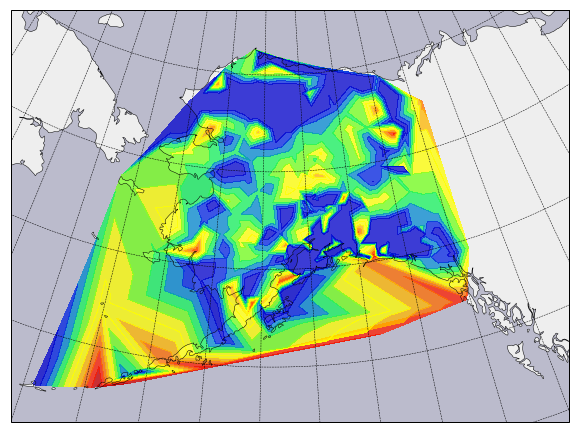

In [9]:

fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))

ax.set_extent([-175,-130,50,72])

ax.add_feature(ocean, alpha=0.5, zorder=1, facecolor="#BBBBCC")
ax.add_feature(land, alpha=1.0, zorder=2, facecolor="#EEEEEE")

ax.coastlines(resolution="50m",color="#000000", linewidth=0.5, zorder=9)
ax.add_feature(grat, linewidth=0.5, 
                     linestyle="--",
                      edgecolor="#000000", 
                      facecolor="None", zorder=10)

lons = np.degrees(datagrid.lons)
lats = np.degrees(datagrid.lats)
moho  = moho_data['moh']


ax.tricontourf(lons, lats, datagrid.simplices, moho, zorder=5, levels=np.linspace(20.0, 40.0, 11),
               extend='both',
               cmap=msmcmap, alpha=0.75, transform=ccrs.PlateCarree())

### Interpolate to a fine spherical triangulation

A consistent interpolation algorithm which properly respects great-circle distances might be important at these high latitudes so we first
try interpolating the data from the original triangulation to a fine, regular grid which we then contour and plot

In [10]:
## Map everything to a regular triangulation for plotting and to demonstrate how interpolation works.

## Define starting grid

grid1r = stripy.spherical_meshes.icosahedral_mesh(include_face_points=False, refinement_levels=8, tree=True)

## Drop points outside the region of interest

angles = grid1r.angular_separation( grid1r.lons, grid1r.lats, np.radians(-158.0) * np.ones_like(grid1r.lons), 
                                   np.radians(62.0) * np.ones_like(grid1r.lats) ) 

nodes = np.where(angles < np.radians(20.0))

lons1 = grid1r.lons[nodes]%(2.0*np.pi)
lats1 = grid1r.lats[nodes]

# identify points within X degrees of a data point

grid1 = stripy.sTriangulation(datagrid.lons, datagrid.lats, tree=True)
near_nodes, distances = grid1.nearest_vertex(lons1, lats1) 
nodes = np.where(distances < 0.075)[0]

# # Now identify points within triangles

# i, err = datagrid.interpolate(lons1, lats1, np.ones_like(datagrid.lons))
# nodes = np.where(err==0)

gridF = stripy.sTriangulation(lons1[nodes]%(2.0*np.pi), lats1[nodes], permute=True)

# Use this as a quality measure 

distances_k, near_nodes = grid1.nearest_vertices(gridF.lons, gridF.lats, k=10) 
distances = distances_k.mean(axis=1)
interpolation_quality_d = np.maximum(0.0, 1.0 - 1.0*distances / distances.mean())

In [11]:
gridF_interpolation, err = datagrid.interpolate(gridF.lons, gridF.lats, moho, order=1)

In [12]:
def alaska_plot2(filename, grid, data, quality, plot_range=[25.0, 50.0], cmap=None ):
    
    goodgrid = grid
    interpolation_quality = quality
    grid_data = data
    if cmap == None:
        cmap = plt.cm.RdYlBu

    fig = plt.figure(figsize=(15, 8), facecolor=None)
    ax1  = plt.subplot(111, projection=ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50, 
                                                       standard_parallels=(55,65) ))
    ax1.set_extent([-175,-130,50,72])
    ax1.coastlines(resolution="50m",color="#000066", linewidth=0.5, zorder=99)

    lons = np.degrees(goodgrid.lons)%360.0
    lats = np.degrees(goodgrid.lats)

    cnt0=ax1.tricontourf(lons, lats, goodgrid.simplices, grid_data, 
                   cmap=cmap, alpha=1.0, levels=np.linspace(plot_range[0], plot_range[1], 10),
                   extend="max", 
                   transform=ccrs.PlateCarree(), zorder=0)
    
    # This is the fix for the white lines between contour levels
    
    for c in cnt0.collections:
        c.set_linewidth(0.0)
        c.set_edgecolor("None")

    ## Mask by "quality" of the interpolation
    
    cnt1 = ax1.tricontourf(lons, lats, goodgrid.simplices, interpolation_quality, 
                       levels=[ 0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 1.0],
                       colors=[(1.0,1.0,1.0,1.0), (1.0,1.0,1.0,0.9),
                               (1.0,1.0,1.0,0.8), (1.0,1.0,1.0,0.6),
                               (1.0,1.0,1.0,0.4),(1.0,1.0,1.0,0.2),
                               (1.0,1.0,1.0,0.0)], extend="both",
                       transform=ccrs.PlateCarree(), zorder=10)  
    
    # This is the fix for the white lines between contour levels
    
    for c in cnt1.collections:
        c.set_edgecolor("#00000000")
        c.set_linewidth(0.0)

    ## Locations of raw data collection


    m = ax1.scatter(moho_data['lon'], moho_data['lat'],  color="White",
                   edgecolor="Black", linewidth=1.0, 
                   marker="o", s=30.0, transform=ccrs.Geodetic(), zorder=25)

 

    plt.colorbar(ax=ax1, mappable=cnt0, shrink=0.5, extend='max', drawedges=False )

    print("Saving {}".format(filename))
    
    from PIL import ImageChops
    from PIL import Image
    import io, os
    
    filename_base, filename_ext = os.path.splitext(filename)

    im_buffer = io.BytesIO()
    fig.savefig(im_buffer, format='png', dpi=600)
    
    im_buffer.seek(0)
    im = Image.open(im_buffer)

    imbg = Image.open("AlaskaMohoImgBg.png")
    imblend = ImageChops.multiply(imbg,im)
    imblend.save("{}+bg.png".format(filename_base))
    im_buffer.close()

    return
    
    
alaska_plot2("MSM-AlaskaMoho-ContourRawTriangulation.png", gridF, gridF_interpolation, 
            interpolation_quality_d, plot_range=[20, 40], cmap=msmcmap)

Saving MSM-AlaskaMoho-ContourRawTriangulation.png
